1. Importing Libraries
2. Loading Data
3. Data Wrangling
4. Feature Selection using Correlation Matrix
5. Feature Selection using SelectKBest Method
6. Feature Selection using Extra Tree Classifier
7. Feature Engineering with BoxCox, Log, Min-Max and Standard transformation
8. Preparing data - Standardisation and Splitting
9. Prediction with XGBoost
10. Using MultiLayer Perceptron for prediction

# Importing Libraries

In [138]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split

# !pip install xgboost
import xgboost as xgb

from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Sequential
from collections import Counter

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Loading Data

In [140]:
data = pd.read_csv("SolarPrediction.csv")

In [141]:
data.head(5)

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


In [142]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10398 entries, 0 to 10397
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                10398 non-null  int64  
 1   Data                    10398 non-null  object 
 2   Time                    10398 non-null  object 
 3   Radiation               10398 non-null  float64
 4   Temperature             10398 non-null  int64  
 5   Pressure                10398 non-null  float64
 6   Humidity                10398 non-null  int64  
 7   WindDirection(Degrees)  10398 non-null  float64
 8   Speed                   10398 non-null  float64
 9   TimeSunRise             10398 non-null  object 
 10  TimeSunSet              10398 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 893.7+ KB


# Data Wrangling

In [144]:
df = data.copy()

In [145]:
# extract the date from the date_time format of the 'Data' parameter
df['Data'] = df['Data'].apply(lambda x : x.split()[0])

In [166]:
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


In [170]:
# extract the date time features from the given parameter using date time python methods
df['Month'] = pd.to_datetime(df['Data'] ,format='mixed').dt.month
df['Day'] = pd.to_datetime(df['Data'],format='mixed').dt.day
df['Hour'] = pd.to_datetime(df['Time'],format='mixed').dt.hour
df['Minute'] = pd.to_datetime(df['Time'],format='mixed').dt.minute
df['Second'] = pd.to_datetime(df['Time'],format='mixed').dt.second

In [172]:
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,Month,Day,Hour,Minute,Second
0,1475229326,9/29/2016,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00,9,29,23,55,26
1,1475229023,9/29/2016,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00,9,29,23,50,23
2,1475228726,9/29/2016,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00,9,29,23,45,26
3,1475228421,9/29/2016,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00,9,29,23,40,21
4,1475228124,9/29/2016,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00,9,29,23,35,24


In [174]:
# extract the sunrise and sunset information using regular expression
df['risehour'] = df['TimeSunRise'].apply(lambda x : re.search(r'^\d+', x).group(0)).astype(int)
df['riseminuter'] = df['TimeSunRise'].apply(lambda x : re.search(r'(?<=\:)\d+(?=\:)', x).group(0)).astype(int)

df['sethour'] = df['TimeSunSet'].apply(lambda x : re.search(r'^\d+', x).group(0)).astype(int)
df['setminute'] = df['TimeSunSet'].apply(lambda x : re.search(r'(?<=\:)\d+(?=\:)', x).group(0)).astype(int)

In [176]:
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,Month,Day,Hour,Minute,Second,risehour,riseminuter,sethour,setminute
0,1475229326,9/29/2016,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00,9,29,23,55,26,6,13,18,13
1,1475229023,9/29/2016,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00,9,29,23,50,23,6,13,18,13
2,1475228726,9/29/2016,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00,9,29,23,45,26,6,13,18,13
3,1475228421,9/29/2016,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00,9,29,23,40,21,6,13,18,13
4,1475228124,9/29/2016,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00,9,29,23,35,24,6,13,18,13


In [178]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10398 entries, 0 to 10397
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                10398 non-null  int64  
 1   Data                    10398 non-null  object 
 2   Time                    10398 non-null  object 
 3   Radiation               10398 non-null  float64
 4   Temperature             10398 non-null  int64  
 5   Pressure                10398 non-null  float64
 6   Humidity                10398 non-null  int64  
 7   WindDirection(Degrees)  10398 non-null  float64
 8   Speed                   10398 non-null  float64
 9   TimeSunRise             10398 non-null  object 
 10  TimeSunSet              10398 non-null  object 
 11  Month                   10398 non-null  int32  
 12  Day                     10398 non-null  int32  
 13  Hour                    10398 non-null  int32  
 14  Minute                  10398 non-null

In [180]:
# drop the parameters that are not required after extracting the relevant information
df.drop(['UNIXTime', 'Data', 'Time', 'TimeSunRise', 'TimeSunSet'], axis = 1, inplace = True)

In [182]:
df.head()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,risehour,riseminuter,sethour,setminute
0,1.21,48,30.46,59,177.39,5.62,9,29,23,55,26,6,13,18,13
1,1.21,48,30.46,58,176.78,3.37,9,29,23,50,23,6,13,18,13
2,1.23,48,30.46,57,158.75,3.37,9,29,23,45,26,6,13,18,13
3,1.21,48,30.46,60,137.71,3.37,9,29,23,40,21,6,13,18,13
4,1.17,48,30.46,62,104.95,5.62,9,29,23,35,24,6,13,18,13


In [184]:
# check of data dimensions
df.shape

(10398, 15)

In [186]:
# checking for null values in the data
df.isnull().sum().sum()

0

In [188]:
# glimpse of the final data
df.head()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,risehour,riseminuter,sethour,setminute
0,1.21,48,30.46,59,177.39,5.62,9,29,23,55,26,6,13,18,13
1,1.21,48,30.46,58,176.78,3.37,9,29,23,50,23,6,13,18,13
2,1.23,48,30.46,57,158.75,3.37,9,29,23,45,26,6,13,18,13
3,1.21,48,30.46,60,137.71,3.37,9,29,23,40,21,6,13,18,13
4,1.17,48,30.46,62,104.95,5.62,9,29,23,35,24,6,13,18,13


In [190]:
np.array(df['Radiation'])

array([  1.21,   1.21,   1.23, ..., 149.01, 185.21, 366.71])

In [192]:
df.shape

(10398, 15)

In [194]:
input_features = df.drop('Radiation', axis = 1)
target = df['Radiation']

# Feature Selection using Correlation Matrix

$$
r=\frac{\sum\left(x_i-\bar{x}\right)\left(y_i-\bar{y}\right)}{\sqrt{\sum\left(x_i-\bar{x}\right)^2 \sum\left(y_i-\bar{y}\right)^2}}
$$
- $r=$ correlation coefficient
- $x_i=$ values of the $\mathrm{x}$-variable in a sample
- $\bar{x}=$ mean of the values of the $\mathrm{x}$-variable
- $y_i=$ values of the $y$-variable in a sample
- $\bar{y}=$ mean of the values of the $y$-variable

In [197]:
# extract the correlation between the data features
corr_matrix = df.corr()
corr_matrix

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,risehour,riseminuter,sethour,setminute
Radiation,1.000000,0.759523,0.093040,-0.357524,-0.223704,0.159253,-0.009766,0.033778,-0.014160,0.004847,-0.015943,NaN,-0.001744,0.009766,-0.032695
Temperature,0.759523,1.000000,0.224926,-0.312932,-0.203123,0.027223,-0.274730,-0.122623,0.181334,-0.002809,-0.184995,NaN,-0.255856,0.274730,-0.262557
Pressure,0.093040,0.224926,1.000000,-0.016988,0.037337,-0.041203,-0.084126,-0.083163,0.214509,0.002121,-0.153452,NaN,-0.093241,0.084126,-0.052235
Humidity,-0.357524,-0.312932,-0.016988,1.000000,-0.027176,-0.169422,0.075709,-0.073157,0.112847,-0.003859,-0.073914,NaN,0.047756,-0.075709,0.138626
WindDirection(Degrees),-0.223704,-0.203123,0.037337,-0.027176,1.000000,0.009936,-0.068157,-0.116359,-0.119988,-0.014187,-0.097587,NaN,-0.090174,0.068157,-0.015437
Speed,0.159253,0.027223,-0.041203,-0.169422,0.009936,1.000000,0.120671,0.110672,-0.107537,-0.005882,0.053019,NaN,0.124502,-0.120671,0.081124
Month,-0.009766,-0.274730,-0.084126,0.075709,-0.068157,0.120671,1.000000,0.552665,0.011604,0.001424,0.272671,NaN,0.951547,-1.000000,0.876266
Day,0.033778,-0.122623,-0.083163,-0.073157,-0.116359,0.110672,0.552665,1.000000,-0.001394,0.003845,0.469289,NaN,0.774583,-0.552665,0.084148
Hour,-0.014160,0.181334,0.214509,0.112847,-0.119988,-0.107537,0.011604,-0.001394,1.000000,-0.000560,0.023232,NaN,0.005279,-0.011604,0.013399
Minute,0.004847,-0.002809,0.002121,-0.003859,-0.014187,-0.005882,0.001424,0.003845,-0.000560,1.000000,0.003323,NaN,0.002284,-0.001424,-0.000550


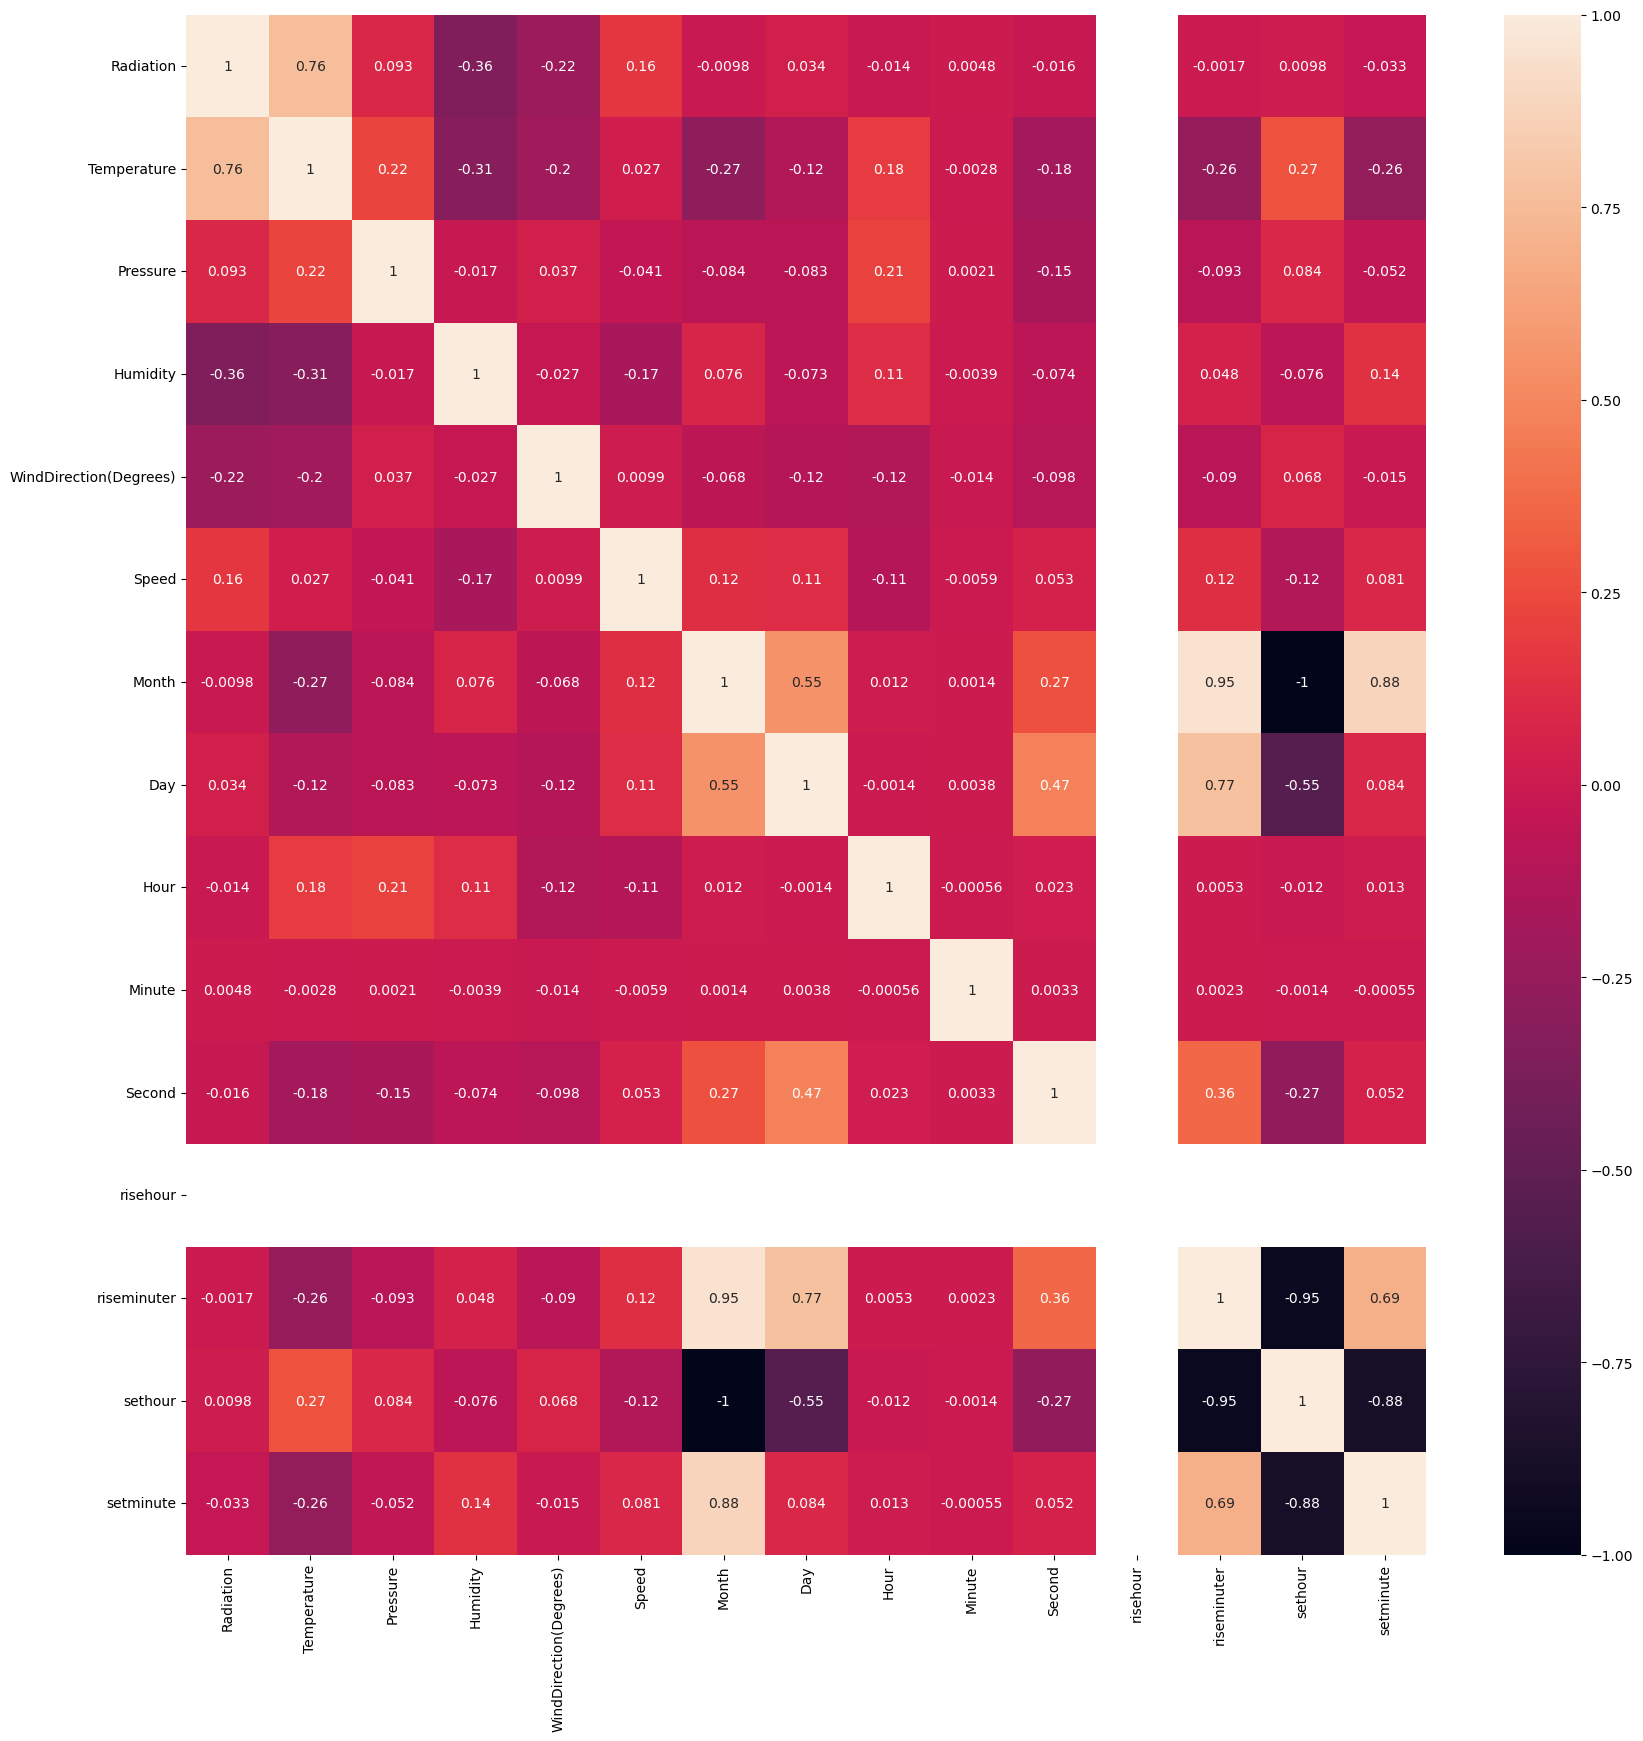

In [199]:
# plot the correlation matrix using heatmap for clear understanding
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(), annot=True)
plt.show()

# Feature Selection using SelectKBest Method

In [202]:
bestfeatures = SelectKBest(score_func = chi2, k = 10)

In [204]:
# use the label encoder
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
train_Y = label_encoder.fit_transform(target)

In [206]:

target_cont = df['Radiation'].apply(lambda x : int(x*100))
scaled_input_features = MinMaxScaler().fit_transform(input_features)
fit = bestfeatures.fit(scaled_input_features, target_cont)

In [208]:
scores = pd.DataFrame(fit.scores_)
column = pd.DataFrame(input_features.columns)

In [210]:
# contatinating data_features with the scores
featureScores = pd.concat([column, scores], axis=1)

#naming the dataframe columns
featureScores.columns = ['Features', 'feature_imp'] 

In [212]:
# best features
featureScores.sort_values(by = 'feature_imp', ascending=False, inplace=True)
featureScores

,Features,feature_imp
5,Month,4664.752867
11,riseminuter,2119.104304
12,sethour,1874.831913
6,Day,1329.160218
13,setminute,1285.273152
3,WindDirection(Degrees),1194.636387
8,Minute,1009.655682
0,Temperature,941.514177
4,Speed,432.297815
9,Second,407.240662


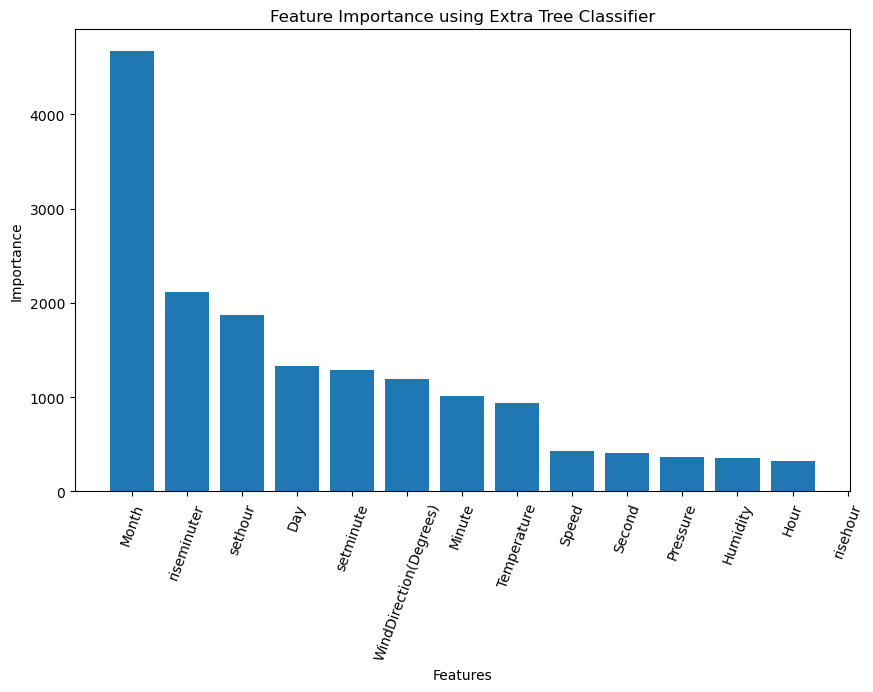

In [214]:
# visualise the feature importance
plt.figure(figsize = (10, 6))
plt.bar(featureScores.Features, featureScores.feature_imp)
plt.xticks(rotation = 70)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance using Extra Tree Classifier")
plt.show()

# Feature Selection using Extra Tree Classifier

In [216]:
model = ExtraTreesClassifier(n_estimators=5, bootstrap=True)
scaled_input_features = scaled_input_features[:, :50]  # Use first 50 features
model.fit(scaled_input_features, target_cont)

ExtraTreesClassifier(bootstrap=True, n_estimators=5)

In [218]:
feature_importances = pd.DataFrame(model.feature_importances_, index = input_features.columns, columns = ["feature_imp"])
feature_importances.sort_values(by = 'feature_imp', ascending=False, inplace = True)
feature_importances

,feature_imp
WindDirection(Degrees),0.148166
Minute,0.136294
Speed,0.117791
Second,0.116713
Humidity,0.114659
Hour,0.101426
Temperature,0.095397
Pressure,0.082366
Day,0.036365
setminute,0.031730


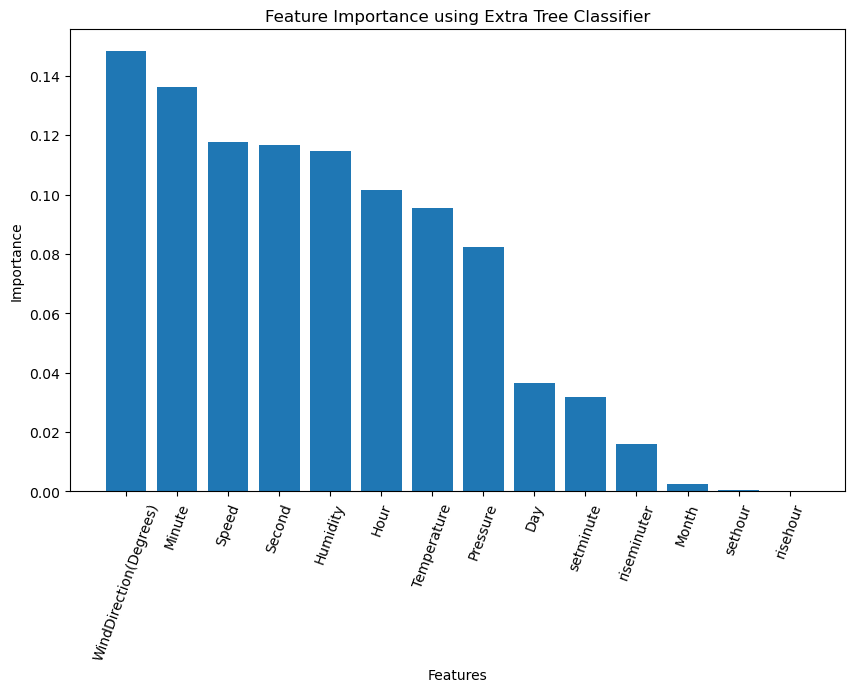

In [220]:
plt.figure(figsize = (10, 6))
plt.bar(feature_importances.index, feature_importances["feature_imp"])
plt.xticks(rotation = 70)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance using Extra Tree Classifier")
plt.show()

# Feature Engineering with BoxCox, Log, Min-Max and Standard transformation

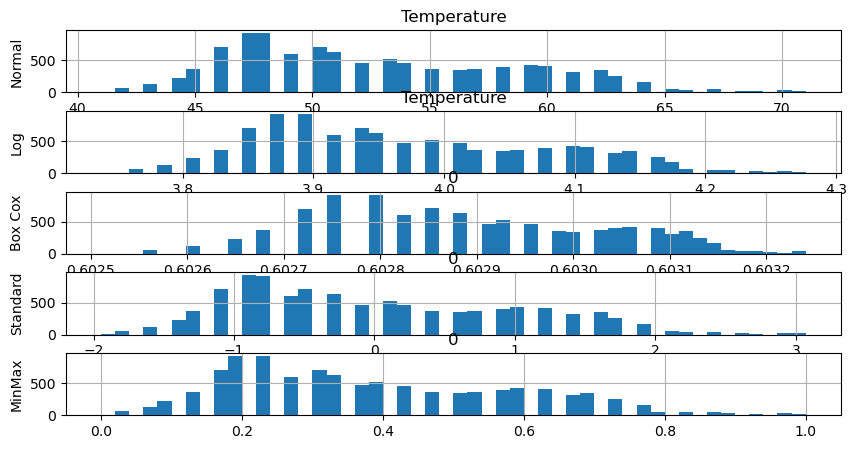

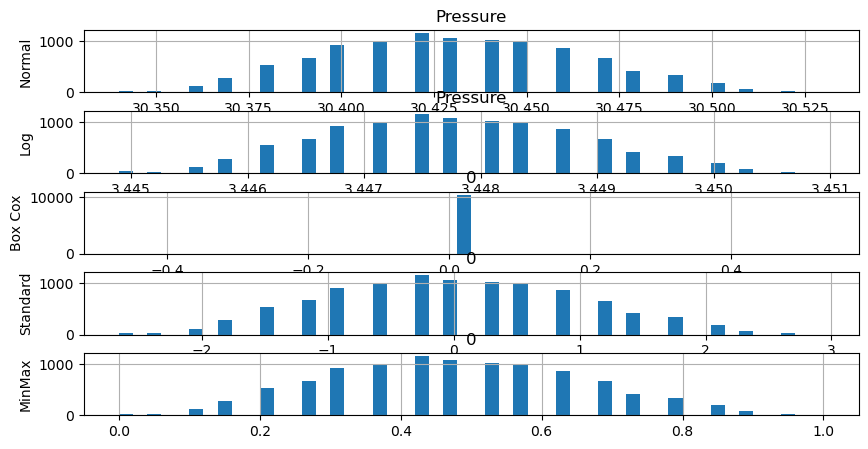

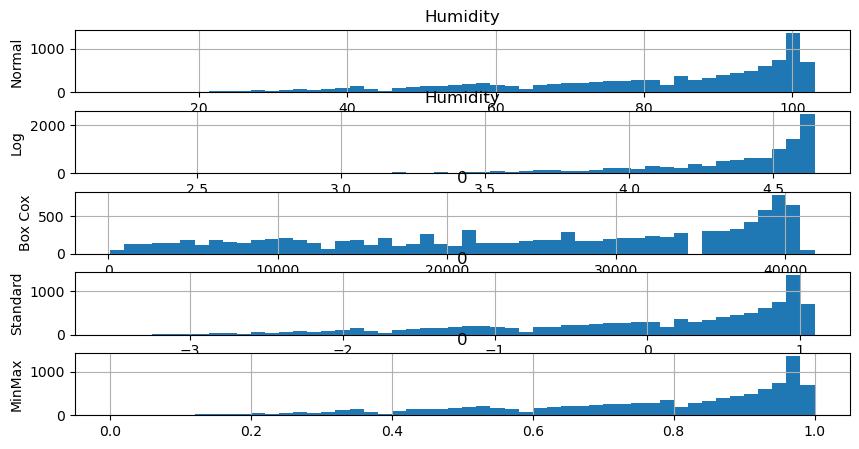

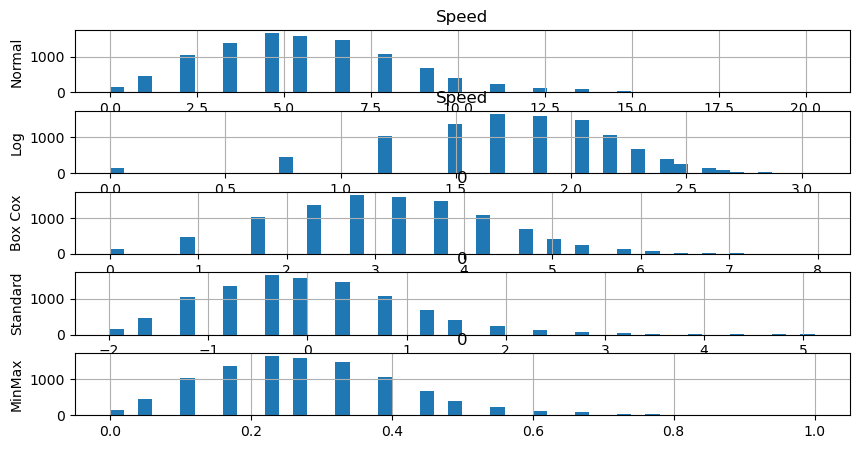

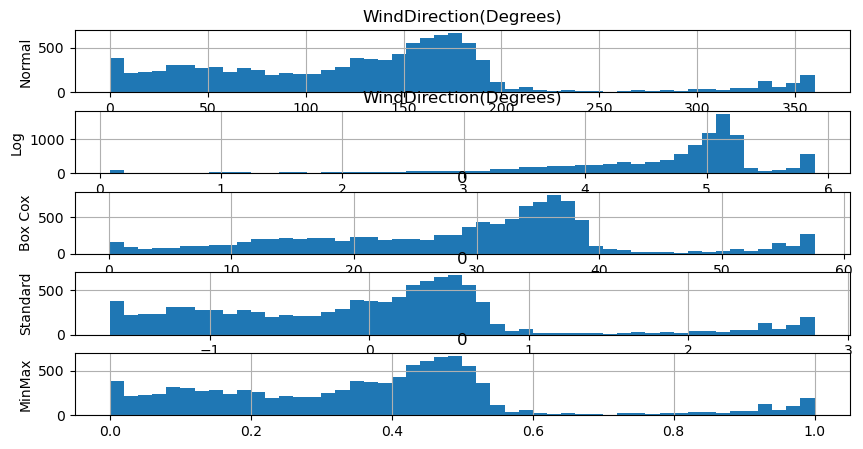

In [223]:
# Looking for transformation
features_to_transform = ['Temperature', 'Pressure', 'Humidity', 'Speed', 'WindDirection(Degrees)']

for i in features_to_transform:
    
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(10, 5))
    
    pd.DataFrame(input_features[i]).hist(ax = ax1, bins = 50)
    pd.DataFrame((input_features[i]+1).transform(np.log)).hist(ax = ax2, bins = 50)
    pd.DataFrame(stats.boxcox(input_features[i]+1)[0]).hist(ax = ax3, bins = 50)    
    pd.DataFrame(StandardScaler().fit_transform(np.array(input_features[i]).reshape(-1, 1))).hist(ax = ax4, bins = 50)
    pd.DataFrame(MinMaxScaler().fit_transform(np.array(input_features[i]).reshape(-1, 1))).hist(ax = ax5, bins = 50)
    
    ax1.set_ylabel('Normal')
    ax2.set_ylabel('Log')
    ax3.set_ylabel('Box Cox')
    ax4.set_ylabel('Standard')
    ax5.set_ylabel('MinMax')

In [225]:
# set the transformations required
transform = {'Temperature' : (input_features['Temperature']+1).transform(np.log), 
             'Pressure': stats.boxcox(input_features['Pressure']+1)[0], 
            'Humidity' : stats.boxcox(input_features['Humidity']+1)[0], 
            'Speed' : (input_features['Speed']+1).transform(np.log), 
            'WindDirection(Degrees)' : MinMaxScaler().fit_transform(
                np.array(input_features['WindDirection(Degrees)']).reshape(-1, 1))}

for i in transform:
    input_features[i] = transform[i]

In [227]:
input_features.head()

,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,risehour,riseminuter,sethour,setminute
0,3.89182,0.031398,10623.384625,0.492719,1.890095,9,29,23,55,26,6,13,18,13
1,3.89182,0.031398,10188.503402,0.491024,1.474763,9,29,23,50,23,6,13,18,13
2,3.89182,0.031398,9764.444448,0.440918,1.474763,9,29,23,45,26,6,13,18,13
3,3.89182,0.031398,11069.177027,0.382448,1.474763,9,29,23,40,21,6,13,18,13
4,3.89182,0.031398,11993.847251,0.291407,1.890095,9,29,23,35,24,6,13,18,13


# Preparing data - Standardisation and Splitting

In [230]:
xtrain, xtest, ytrain, ytest = train_test_split(input_features, target, test_size=0.2, random_state=1)

scaler = StandardScaler()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)

In [232]:
xtrain.shape, xtest.shape

((8318, 14), (2080, 14))

# Prediction with XGBoost

In [235]:
# declare parameters
params = {
    'learning_rate': 0.1,
    'max_depth': 8}

from xgboost import XGBRegressor
model = XGBRegressor(**params)

In [237]:
# train the model
model.fit(xtrain, ytrain)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [239]:
y_pred = model.predict(xtest)

In [241]:
print('XGBoost model result: {0:0.4f}'. format(np.sqrt(mean_squared_error(ytest, y_pred))))

XGBoost model result: 97.0317


In [243]:
rmse = np.sqrt(mean_squared_error(ytest, y_pred))
r2 = r2_score(ytest, y_pred)

print("Testing performance")

print("RMSE: {:.2f}".format(rmse))
print("R2: {:.2f}".format(r2))

Testing performance
RMSE: 97.03
R2: 0.92


# Using MultiLayer Perceptron for prediction

In [246]:
xtrain, xtest, ytrain, ytest = train_test_split(input_features, target, test_size=0.2, random_state=1)

scaler = StandardScaler()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)

In [250]:
model = None
model = Sequential()
    
model.add(Dense(128, activation='relu', input_dim=14))
model.add(Dropout(0.33))
    
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.33))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.33))

model.add(Dense(1, activation='linear'))
    
model.compile(metrics=['mse'], loss='mae', optimizer=Adam(learning_rate=0.001))
print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 128)                 │           1,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,289 (48.00 KB)

 Trainable params: 12,289 (48.00 KB)

 Non-trainable params: 0 (0.00 B)

None


In [252]:
history = model.fit(xtrain, ytrain, validation_split=0.1, epochs=50, batch_size=32)


Epoch 1/50
234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 211.0231 - mse: 150784.3281 - val_loss: 95.6374 - val_mse: 33073.1758
Epoch 2/50
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 105.9917 - mse: 39373.7891 - val_loss: 82.0844 - val_mse: 25399.3203
Epoch 3/50
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 100.5793 - mse: 36565.0820 - val_loss: 76.5088 - val_mse: 22449.8789
Epoch 4/50
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 94.9854 - mse: 32989.1523 - val_loss: 73.6748 - val_mse: 21129.2324
Epoch 5/50
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 95.6834 - mse: 33535.8984 - val_loss: 70.5647 - val_mse: 19792.8555
Epoch 6/50
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 94.7190 - mse: 32772.7852 - val_loss: 69.7542 - val_mse: 19249.3105
Epoch 7/50
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 90.3802 - mse: 31299.9082 - val_loss: 70.6766 - val_mse: 19867.4297
Epoch 8/50
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 89.5356 - mse: 29152.0586 - val_loss: 67

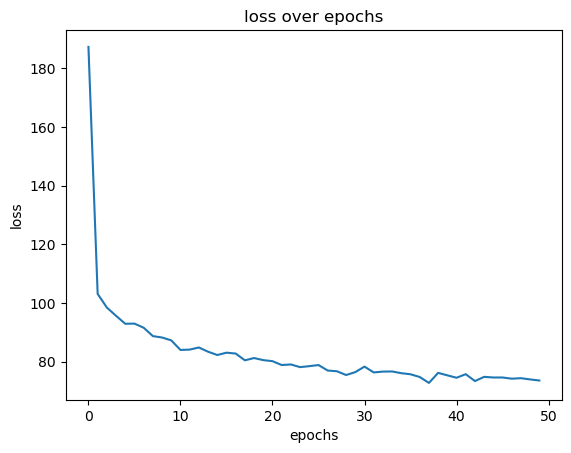

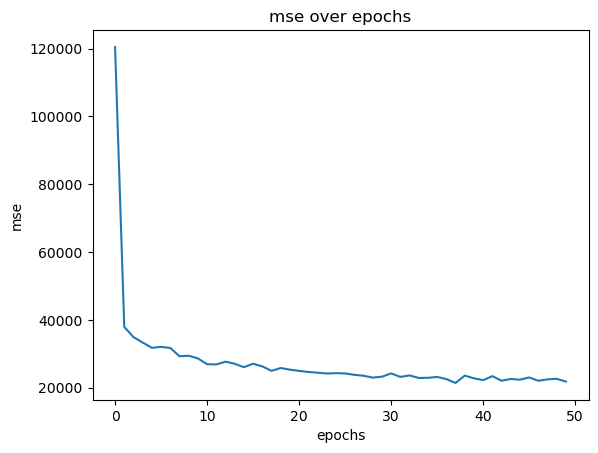

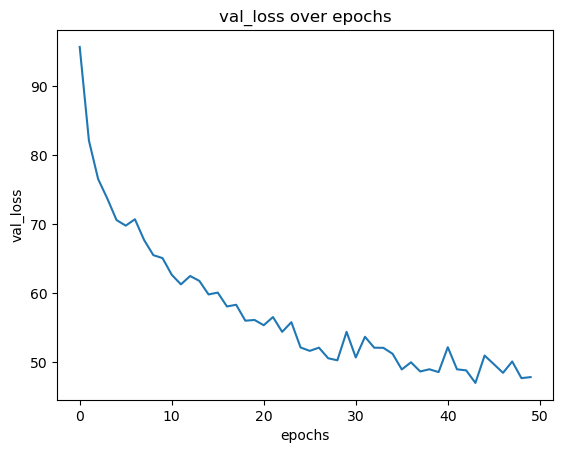

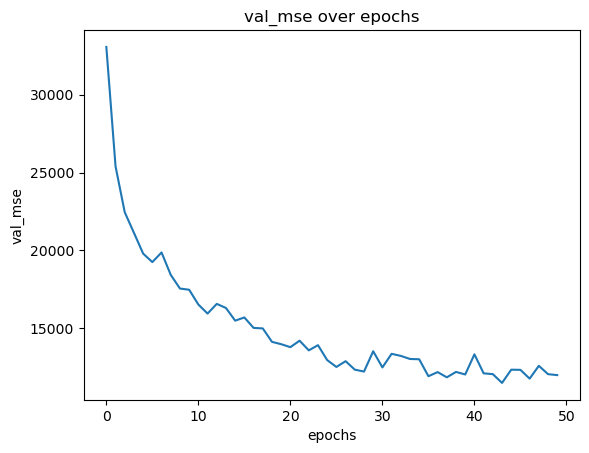

In [254]:
fit = history.history
for i in fit:
    plt.plot(fit[i])
    plt.title(i + ' over epochs')
    plt.ylabel(i)
    plt.xlabel('epochs')
    plt.show()

In [256]:
scores = model.evaluate(xtest, ytest)
mae = scores[0]
mse = scores[1]
print('Mean absolute error: ', mae)

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - loss: 57.5768 - mse: 14438.2070
Mean absolute error:  56.38882064819336


In [258]:
mean_absolute_error(ytest, model.predict(xtest))

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


56.38883088745291